
# Configuração

In [2]:
#Requirido apenas se estiver executando no colab
!pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [3]:
# Tipagem
import typing 
import string
from typing import Any, Tuple, NamedTuple
from string import digits

# Auxiliares
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Core
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras.layers.experimental import preprocessing

# Classe auxliar
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

# Dados

## Carregando os dados

In [4]:
# Para baixar os dados (caso esteja usando o colab):
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_of_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

# função para carregar os dados
def load_data(path):
  text = path.read_text(encoding='utf-8')
  
  #pairs vai ter várias listas, com dois elementos em cada uma: a palavra em Inglês e Espanhol
  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  input = [input for target, input in pairs]
  target = [target for target, input in pairs]

  return target, input

target, input = load_data(path_of_file)
print(f'\nespanhol: {input[-1]}')
print(f'inglês: {target[-1]}')


2654208/2638744 [==============================] - 0s 0us/step

espanhol: Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
inglês: If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


## Estruturando os dados

In [5]:
print(f'tamanho da lista de entradas: {len(input)}')
print(f'tamanho da lista de entradas: {len(target)}')

BUFFER_SIZE = len(input)
BATCH_SIZE = 64

#Vai separar todas as listas (input, target) em partes menores, de acordo com o tamanho por parte (BUFFER_ZISE)
dataset = tf.data.Dataset.from_tensor_slices((input, target)).shuffle(BUFFER_SIZE)

#Combina elementos do dataset em lotes (listas) de acordo com o tamanho (BATCH_SIZE)
dataset = dataset.batch(BATCH_SIZE)

for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break


tamanho da lista de entradas: 118964
tamanho da lista de entradas: 118964
tf.Tensor(
[b'Lamento mucho haberte hecho esperar tanto.'
 b'Ahora un computador es una absoluta necesidad.'
 b'\xc2\xbfElla habla ingl\xc3\xa9s?' b'\xc2\xbfEst\xc3\xa1s mirando?'
 b'Casi fui robado.'], shape=(5,), dtype=string)

tf.Tensor(
[b'I feel bad about having made you wait so long.'
 b'A computer is an absolute necessity now.' b'Does she speak English?'
 b'Are you looking?' b'I almost got robbed.'], shape=(5,), dtype=string)


## Pré processamento do texto

In [6]:
#Aqui neste método há várias regras para processar os textos nas línguas distintas
def tf_lower_and_split_punctuation(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
 
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

tf_lower_and_split_punctuation('¿Todavía está en casa?').numpy().decode()


'[START] ¿ todavia esta en casa ? [END]'

## Vetorização dos textos

In [7]:
max_vocabulary_size = 5000

#O adapt é usado para fazer um treinamento dos vetores em cima dos dados 

#camada de vetorização do input 
input_text_processor = preprocessing.TextVectorization(standardize=tf_lower_and_split_punctuation, max_tokens=max_vocabulary_size)
input_text_processor.adapt(input)

#camada de vetorização do output 
output_text_processor = preprocessing.TextVectorization(standardize=tf_lower_and_split_punctuation, max_tokens=max_vocabulary_size)
output_text_processor.adapt(target)


## Usando as camadas vetorizadas


In [8]:
#As camadas têm capacidade agora de converter uma lista (ou lote) de strings em textos
#E com o vocabulário, pode-se converter os tokens para textos

print(f'Vocabulário da camada input: {input_text_processor.get_vocabulary()[:10]}')
print(f'Vocabulário da camada output: {output_text_processor.get_vocabulary()[:10]}\n')

example_tokens = input_text_processor(example_input_batch)

print(f'Exemplo de tokens: {example_tokens[:3, :10]}\n')
print(f'Tokens da primeira frase: {example_tokens[0]}\n')

input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
first_phrase = ' '.join(tokens)

print(f'Primeira frase "destokenizada": {tokens}\n')
print(f'Primeira frase "destokenizada" e formatada: {first_phrase}')

Vocabulário da camada input: ['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']
Vocabulário da camada output: ['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Exemplo de tokens: [[   2  806   77 1086  162  416  253    4    3    0]
 [   2   90   16 1237   15   23    1 1810    4    3]
 [   2   13   29  219  151   12    3    0    0    0]]

Tokens da primeira frase: [   2  806   77 1086  162  416  253    4    3    0    0    0    0    0
    0    0    0    0    0    0]

Primeira frase "destokenizada": ['[START]' 'lamento' 'mucho' 'haberte' 'hecho' 'esperar' 'tanto' '.'
 '[END]' '' '' '' '' '' '' '' '' '' '' '']

Primeira frase "destokenizada" e formatada: [START] lamento mucho haberte hecho esperar tanto . [END]           


# Modelos

## Codificador

In [9]:
#Variáveis "globais"

embedding_dim = 256 #Dimensão da camada de embedding
units = 1024 #

In [10]:
# Codificador

# Considerações: o uso da classe ShapeChecker() serve para verificar os formatos dos tensores
#                o codificador precisa retornar uma saída codificada e também o seu estado para que seja passado ao decodificador  

# O codificador, simplificando, é uma camada da inteligência de tradução, por isso herda de Layer
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    #Camada de embedding para converter tokens em vetores 
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    #Essa é a camada que processa os vetores sequencialmente (camada RNN) 
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  
  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    #Camada de embedding que procura os tokens
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    #Camada RNN que processa a sequencia de vetores
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    return output, state

### Testando o codificador

In [11]:
#Convertendo a entrada (texto) para tokens
example_tokens = input_text_processor(example_input_batch)

#Tenho 64 frases dentro de "example_input_batch"
print(f'formato do lote de entrada (lote de frases): {example_input_batch.shape}')
print(f'algumas frases do lote: {example_input_batch[:2]}\n')

#Tenho 64 lista de tokens, cada lista contendo 15 tokens
print(f'formato do lote de tokens de entrada (lote de tokens): {example_tokens.shape}')
print(f'alguns tokens que estão sendo passados: {example_tokens[:1]}\n')

#Codificando a sequência de tokens de entrada
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

#Eu tenho uma saída, codificada, com o seguinte shape (x, 15, 1024)
#Onde x é quantidade de frases que passei, 15 é quantidade de tokens e 1024 é a dimensão de cada embedding 
print(f'Saída codificada, shape (batch, s, units): {example_enc_output.shape}')
print(f'Estado de saída, shape (batch, units): {example_enc_state.shape}\n')

#Cada frase vai ter uma lista de tokens que foram vetorizados à embeddings (transformado em uma lista de valores de embeddings)
#Então agora temos 15 listas, referente ao valor dos tokens, e cada lista tem uma lista com 1024 valores de embedding 
print(f'Primeira frase: {example_enc_output[0].shape}')
print(f'Valor de embedding do primeiro token: {example_enc_output[0][0].shape}')

#----
print(f'\nInput batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Input batch tokens, shape (batch, s): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


formato do lote de entrada (lote de frases): (64,)
algumas frases do lote: [b'Lamento mucho haberte hecho esperar tanto.'
 b'Ahora un computador es una absoluta necesidad.']

formato do lote de tokens de entrada (lote de tokens): (64, 20)
alguns tokens que estão sendo passados: [[   2  806   77 1086  162  416  253    4    3    0    0    0    0    0
     0    0    0    0    0    0]]

Saída codificada, shape (batch, s, units): (64, 20, 1024)
Estado de saída, shape (batch, units): (64, 1024)

Primeira frase: (20, 1024)
Valor de embedding do primeiro token: (1024,)

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 20)
Input batch tokens, shape (batch, s): (64, 20, 1024)
Encoder state, shape (batch, units): (64, 1024)


## Atenção  

In [12]:
# a cabeça da camada de atenção a ser usada aqui é a Bahdanau's additive attention. 
# ref: https://arxiv.org/pdf/1409.0473.pdf

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  #query vai ser algo gerado pelo decodificador
  #value é a saída do codificador
  #maks vai servir para excluir o padding
  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### Testando a camada de atenção

In [13]:
attention_layer = BahdanauAttention(units)
print((example_tokens != 0).shape)

#Este é um exemplo de consulta que o decodificador fará
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

#
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Shape do resultado do vetor de atenção: {context_vector.shape}')
print(f'Shape dos pesos retornados da camada de atenção: {attention_weights.shape}')

(64, 20)
Shape do resultado do vetor de atenção: (64, 2, 1024)
Shape dos pesos retornados da camada de atenção: (64, 2, 20)


## Decodificador

In [14]:
#Como são diversos tensores que o decoder recebe e retorna, foi criada classes auxiliares 
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

#O decodificador vai receber a saída inteira do codificador para gerar as previsões.
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    #1º passo: criar camada de Embedding para vetorizar os IDs de tokens
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                embedding_dim)

    #2º passo: a camada GRU para gerar as previsões 
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    #3º passo: gerar a camada de atenção para melhorar a previsão. A saída da camada GRU vai servir como query para esta camada
    self.attention = BahdanauAttention(self.dec_units)

    #4º passo: 
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    #5º passo: uma camada que irá produzir previsões logísticas para cada token de saída
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))
        
  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))
        
  #1º passo. Vetorizando os tokens
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))
        
  #2º passo. Processa o vetor de embeddings com a camada GRU
  rnn_output, state = self.gru(vectors, initial_state=state)
        
  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))
        
  #3º passo. Usa a saída da camda GRU como query para a camada de atenção
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))
        
  #4º passo. Eqn. (3): Join the context_vector and rnn_output [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
        
  #5º passo. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))
        
  #6º passo. Gera as previsões logísticas:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))
        
  return DecoderOutput(logits, attention_weights), state


Decoder.call = call

### Testando o decodificador

In [15]:
# Relembrando os dados

print(f'frase: {example_target_batch[1]}')
print(f'frase vetorizada: {output_text_processor(example_target_batch[1])}')

#O decoder precisa ter o vocabulário para converter os tokens
#A camada de embedding precisa ter o mesmo tamanho da camada do codificador
print(f'embedding: {embedding_dim}')
print(f'unidades: {units}') #Relemebrar

decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

example_output_tokens = output_text_processor(example_target_batch)
start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0]) #revisar isso

# Testando o decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'\nshape do cálculo logístico: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'shape do estado do decoder: (batch_size, dec_units) {dec_state.shape}')

sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

#decodificando os tokens usando o vocabulário
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]

print(f'\nVocabulário: {vocab}')
print(f'Palavras: {first_word[:5]}')

dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
print(f'\nPalavras: {first_word[:5]}')

frase: b'A computer is an absolute necessity now.'
frase vetorizada: [   2   10  576   12   72 2779 3285   95    4    3]
embedding: 256
unidades: 1024

shape do cálculo logístico: (batch_size, t, output_vocab_size) (64, 1, 5000)
shape do estado do decoder: (batch_size, dec_units) (64, 1024)

Vocabulário: ['' '[UNK]' '[START]' ... 'productive' 'printer' 'principles']
Palavras: [['lead']
 ['oranges']
 ['punish']
 ['singapore']
 ['divide']]

Palavras: [['remarkable']
 ['silk']
 ['sun']
 ['potatoes']
 ['boxes']]


# Treinamento


### Construindo a função de perda

In [16]:
#Como o tradutor é uma inteligência mais complexa, necessita de criar as próprias funções que são utilizadas no treinamento
#No caso desta, precisa da: função de perda, otimizador, atualizador de pesos e o ciclo de treinos (epochs)

class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calcula a perda para cada frase no lote (sequência de frases)
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mascara as perdas no padding (? revisar)
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    return tf.reduce_sum(loss)

### Classe de treinamento

In [17]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)


### Método de processamento dos textos (idioma de origem idioma de tradução) 

In [18]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

TrainTranslator._preprocess = _preprocess

### Método para executar o codificador e inicializar o decodificador

In [19]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

TrainTranslator._train_step = _train_step

### Método para executar o decodificador, calcular a perda e o novo estado de decodificador 

In [20]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

TrainTranslator._loop_step = _loop_step

### Fazendo Treinamento

In [21]:
# Instanciando a classe de treino
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configurando a perda e otimizador
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

print(f'A perda deve começar perto de: {np.log(output_text_processor.vocabulary_size())}')

for n in range(10):
    print(f'perda: {translator.train_step([example_input_batch, example_target_batch])}')


A perda deve começar perto de: 8.517193191416238
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5952983>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.564265>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.505688>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3315644>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.6482334>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.569319>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7411885>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.532905>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.356859>}
perda: {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.145889>}


In [22]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])

def _tf_train_step(self, inputs):
  return self._train_step(inputs)

TrainTranslator._tf_train_step = _tf_train_step
translator.use_tf_function = True

translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0030303>}

In [23]:
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9344873>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8984087>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.829944>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.744687>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7342615>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8573058>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6834128>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6681592>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6264856>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5929286>}



....................................................................................................


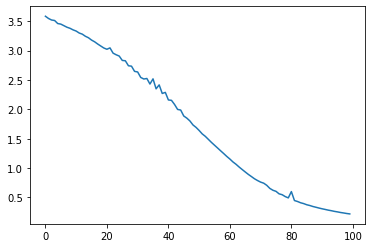

In [24]:
#Gráfico de perda

losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [25]:
#Treinamento real

#criando uma nova cópia
train_translator = TrainTranslator(
    embedding_dim, units, 
    input_text_processor=input_text_processor, 
    output_text_processor=output_text_processor
)

#configurando a loss e otimizador
train_translator.compile(
  optimizer=tf.optimizers.Adam(),
  loss=MaskedLoss(),
)

#definindo a uma classe para recolher o histórico do treinamento
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
1859/1859 [==============================] - 871s 465ms/step - batch_loss: 2.1121
Epoch 2/3
1859/1859 [==============================] - 858s 462ms/step - batch_loss: 1.0456
Epoch 3/3
1859/1859 [==============================] - 876s 471ms/step - batch_loss: 0.8133


In [26]:
#Perda
# plt.plot(batch_loss.logs)
# plt.ylim([0, 3])
# plt.xlabel('Batch #')
# plt.ylabel('CE/token')

# Tradução

### Criando a classe do Tradutor

In [29]:
#classe do Tradutor
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [31]:
#instanciando o tradutor
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

### Método para converter o texto em tokens

In [32]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

Translator.tokens_to_text = tokens_to_text

In [33]:
# testando

example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'teaching divided', b'supplied reduce', b'coming jail',
       b'picasso gloomy', b'amused lot'], dtype=object)

### Método para pegar as previsões

In [34]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

Translator.sample = sample

In [35]:
#Testando
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2566],
       [3885],
       [2745],
       [2910],
       [1426]])>

### Método para executar o fluxo de tradução

In [36]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [58]:
Translator.translate = translate_unrolled

### Traduzindo

In [37]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

this is very cold in here .
this is my enemy .

CPU times: user 367 ms, sys: 5.46 ms, total: 373 ms
Wall time: 372 ms


In [59]:
# translator.translate(input_text = input_text)['text'][0].numpy().decode()

print(f'Frases de teste: {example_input_batch[1]} {example_input_batch[8]}')
print(f'\nResultado esperado: {example_target_batch[1]} {example_target_batch[8]}')

input_text = tf.constant(['Ahora un computador es una absoluta necesidad.', 'No creo que su historia sea cierta'])

test = translator.translate(input_text = input_text)
print('\nPrimeira frase traduzida: {}'.format(test['text'][0].numpy().decode()))
print('Segunda frase traduzida: {}'.format(test['text'][1].numpy().decode()))

Frases de teste: b'Ahora un computador es una absoluta necesidad.' b'No creo que su historia sea cierta.'

Resultado esperado: b'A computer is an absolute necessity now.' b"I don't think her story is true."

Primeira frase traduzida: the a computer now is a painful lawyer .
Segunda frase traduzida: i dont believe his story is true .
